# Predicting the Critical Temperature of a Superconductor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline


# Regresión

[A Data-Driven Statistical Model for Predicting the Critical
Temperature of a Superconductor](https://arxiv.org/pdf/1803.10260.pdf)

En este estudio se crea un modelo estadístico para predecir la [temperatura crítica](https://es.wikipedia.org/wiki/Transici%C3%B3n_de_fase) $T_c$ de materiales superconductores. Este modelo se basa en la fórmula química de los materiales superconductores y de otras características extraídas de esta composición química.

En el dataset la primera columna es informativa y representa la composición del material, la segunda columna contiene la variable objetivo `critical_temp` que representa la temperatura crítica $T_c$ y las demás columnas son las características usadas para la predicción.

In [ ]:
!wget -O superconductor_data.zip https://www.dropbox.com/s/eg4m4jge6zbx23l/superconductor_data.zip?dl=0
superconductor_data = pd.read_csv("superconductor_data.zip", compression="zip", index_col=0)

--2021-10-09 10:39:08--  https://www.dropbox.com/s/eg4m4jge6zbx23l/superconductor_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/eg4m4jge6zbx23l/superconductor_data.zip [following]
--2021-10-09 10:39:09--  https://www.dropbox.com/s/raw/eg4m4jge6zbx23l/superconductor_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb751a91606b406d0047b23b26.dl.dropboxusercontent.com/cd/0/inline/BXvtZZ6zNS3dwARfNh869O9bBpg5tf9wPkUt5Ifz6Egfu4QzZkq1SrKVZchJD265kzI3XMtl9TQNtwdtAyqkb1-dgXZS1KFJZ9e3NjFMzZq-P_Gdd7SYJKqe_R_eKO2Xs3P3YgkTSBLog7PcWWI4Y4p9/file# [following]
--2021-10-09 10:39:09--  https://uccb751a91606b406d0047b23b26.dl.dropboxusercontent.com/cd/0/inline/BXvtZZ6zNS3dwARfNh869O9bBpg5tf9wPkUt5Ifz6Egfu4QzZk

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [ ]:
# Dataset
superconductor_data.head()

,material,critical_temp,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,...,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp.1
0,Ba0.2La1.8Cu1O4,29.0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,53.622535,775.425,1010.268571,718.152900,938.016780,1.305967,0.791488,810.6,735.985714,323.811808,355.562967,160.25,105.514286,136.126003,84.528423,1.259244,1.207040,205,42.914286,75.237540,69.235569,4654.35725,2961.502286,724.953211,53.543811,1.033129,0.814598,8958.571,...,111.727143,60.123179,99.414682,1.159687,0.787382,127.05,80.987143,51.433712,42.558396,6.9055,3.846857,3.479475,1.040986,1.088575,0.994998,12.878,1.744571,4.599064,4.666920,107.756645,61.015189,7.062488,0.621979,0.308148,0.262848,399.97342,57.127669,168.854244,138.517163,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,Ba0.1La1.9Ag0.1Cu0.9O4,26.0,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,53.979870,766.440,1010.612857,720.605511,938.745413,1.544145,0.807078,810.6,743.164286,290.183029,354.963511,161.20,104.971429,141.465215,84.370167,1.508328,1.204115,205,50.571429,67.321319,68.008817,5821.48580,3021.016571,1237.095080,54.095718,1.314442,0.914802,10488.571,...,112.316429,69.833315,101.166398,1.427997,0.838666,127.05,81.207857,49.438167,41.667621,7.7844,3.796857,4.403790,1.035251,1.374977,1.073094,12.878,1.595714,4.473363,4.603000,172.205316,61.372331,16.064228,0.619735,0.847404,0.567706,429.97342,51.413383,198.554600,139.630922,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,Ba0.1La1.9Cu1O4,19.0,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,53.656268,775.425,1010.820000,718.152900,939.009036,1.305967,0.773620,810.6,743.164286,323.811808,354.804183,160.25,104.685714,136.126003,84.214573,1.259244,1.132547,205,49.314286,75.237540,67.797712,4654.35725,2999.159429,724.953211,53.974022,1.033129,0.760305,8958.571,...,112.213571,60.123179,101.082152,1.159687,0.786007,127.05,81.207857,51.433712,41.639878,6.9055,3.822571,3.479475,1.037439,1.088575,0.927479,12.878,1.757143,4.599064,4.649635,107.756645,60.943760,7.062488,0.619095,0.308148,0.250477,399.97342,57.127669,168.854244,138.540613,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
4,Ba0.3La1.7Cu1O4,23.0,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,53.588771,775.425,1009.717143,718.152900,937.025573,1.305967,0.805230,810.6,728.807143,

In [ ]:
# Original shape
superconductor_data.shape

(19162, 84)

In [ ]:
# Drop the unnecesary columns 
X_super = superconductor_data.drop(['material', 'critical_temp', 'critical_temp.1'], axis=1)
y_super = superconductor_data['critical_temp']

X_super.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,53.622535,775.425,1010.268571,718.152900,938.016780,1.305967,0.791488,810.6,735.985714,323.811808,355.562967,160.25,105.514286,136.126003,84.528423,1.259244,1.207040,205,42.914286,75.237540,69.235569,4654.35725,2961.502286,724.953211,53.543811,1.033129,0.814598,8958.571,1579.583429,3306.162897,...,81.8375,111.727143,60.123179,99.414682,1.159687,0.787382,127.05,80.987143,51.433712,42.558396,6.9055,3.846857,3.479475,1.040986,1.088575,0.994998,12.878,1.744571,4.599064,4.666920,107.756645,61.015189,7.062488,0.621979,0.308148,0.262848,399.97342,57.127669,168.854244,138.517163,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,53.979870,766.440,1010.612857,720.605511,938.745413,1.544145,0.807078,810.6,743.164286,290.183029,354.963511,161.20,104.971429,141.465215,84.370167,1.508328,1.204115,205,50.571429,67.321319,68.008817,5821.48580,3021.016571,1237.095080,54.095718,1.314442,0.914802,10488.571,1667.383429,3767.403176,...,90.8900,112.316429,69.833315,101.166398,1.427997,0.838666,127.05,81.207857,49.438167,41.667621,7.7844,3.796857,4.403790,1.035251,1.374977,1.073094,12.878,1.595714,4.473363,4.603000,172.205316,61.372331,16.064228,0.619735,0.847404,0.567706,429.97342,51.413383,198.554600,139.630922,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,53.656268,775.425,1010.820000,718.152900,939.009036,1.305967,0.773620,810.6,743.164286,323.811808,354.804183,160.25,104.685714,136.126003,84.214573,1.259244,1.132547,205,49.314286,75.237540,67.797712,4654.35725,2999.159429,724.953211,53.974022,1.033129,0.760305,8958.571,1667.383429,3306.162897,...,81.8375,112.213571,60.123179,101.082152,1.159687,0.786007,127.05,81.207857,51.433712,41.639878,6.9055,3.822571,3.479475,1.037439,1.088575,0.927479,12.878,1.757143,4.599064,4.649635,107.756645,60.943760,7.062488,0.619095,0.308148,0.250477,399.97342,57.127669,168.854244,138.540613,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,53.588771,775.425,1009.717143,718.152900,937.025573,1.305967,0.805230,810.6,728.8071

In [ ]:
# Get the features names
features = superconductor_data.columns.delete([0,1,-1])
features[:10]

Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass'],
      dtype='object')

In [ ]:
# Split Train and test sets
X_train_super, X_test_super, y_train_super, y_test_super = train_test_split(X_super, y_super, test_size=0.3, random_state=42)


In [ ]:
#Train
linear_regression  = LinearRegression(normalize=True)
linear_regression.fit(X_train_super,y_train_super)

#Predictions
y_pred_super = linear_regression.predict(X_test_super)

#Test de pearson, que tan lineal son los datos
print('R2 =',linear_regression.score(X_test_super, y_test_super))
print('MSE: ', mean_squared_error(y_test_super, y_pred_super))

linear_regression.coef_

# Metrics
print('MAE: ', mean_absolute_error(y_test_super, y_pred_super))

print("Number of features used: {}".format(np.sum(linear_regression.coef_ != 0)))

R2 = 0.734969359553935
MSE:  313.8118597599464
MAE:  13.458777169492535
Number of features used: 81


### Regresión Lasso

Realiza una regularización $L_1$, forzando a que algunos coeficientes sean exactamente cero.

$$\sum (Y_i-\hat Y_i)^2+\alpha \sum |w_i|$$

Lo anterior implica que algunas características sean ingnoradas completamente del modelo. Este modelo implica una forma de selección automática de características. En este caso, se deben normalizar o estandarizar los datos. 

In [ ]:
def modelRegression(model, param, X_train, X_test, y_train, y_test):

  regression = GridSearchCV(model, param, scoring="r2",verbose=0)
  regression.fit(X_train, y_train)

  print(regression.best_params_)

  #Predictions
  y_pred = regression.predict(X_test)

  #Test de pearson, que tan lineal son los datos
  print('R2 %.3f' % regression.score(X_test, y_test))

  return y_pred, regression.best_params_

In [ ]:
laso_parmas = {'alpha': np.linspace(0.0001, 0.1)}
y_pred_laso, best_params_laso = modelRegression(Lasso(), laso_parmas, X_train_super, X_test_super, y_train_super, y_test_super)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1664869.297856335, tolerance: 1252.0825008823515
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1666403.755079985, tolerance: 1258.874200764318
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1664805.2953714486, tolerance: 1257.4671252870792
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1658118.2

{'alpha': 0.0021387755102040816}
R2 0.732


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2090532.6497287068, tolerance: 1564.744263137602
  positive)


### Regresión Ridge

La penalización se hace mediante el hiper parámetro $\alpha$:

$$\sum (Y_i-\hat Y_i)^2+\alpha \sum w_i^2 $$


Haciendo que sean más pequeños los coeficientes y estabilizando las soluciones aunque a costa de una menor sensibilidad a los datos. 

In [ ]:
ridge_parmas = {'alpha': np.linspace(0.1, 100)}
y_pred_ridge, best_params_ridge = modelRegression(Ridge(), ridge_parmas, X_train_super, X_test_super, y_train_super, y_test_super )


{'alpha': 0.1}
R2 0.735


### Redes elásticas:
A las regresiones que usan una combinación de ambas penalidades ($L_1$ y $L_2$) se les conoce como **ElasticNet** (Redes elásticas) y definimos su error como:
$$\sum (Y_i- \hat Y_i)^2+\alpha \rho \sum |w_i| + \frac{\alpha(1-\rho)}{2}\sum w_i^2. $$

Note que cuando $ \rho=1$ tenemos la regresión Lasso, y con $\rho=0$ tendremos la de Ridge, por tanto en las redes elásticas $0\leq \rho\leq1$.

In [ ]:
elastic_param = [{'alpha': [0.001, 0.1, 1.0],
                  'l1_ratio': [0, 0.25, 0.5, 0.75, 1]}]
y_pred_elast, best_params_elast = modelRegression(ElasticNet(), elastic_param, X_train_super, X_test_super, y_train_super, y_test_super )


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1684785.9526857422, tolerance: 1252.0825008823515
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1689133.3415286366, tolerance: 1258.874200764318
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1686279.234671834, tolerance: 1257.4671252870792
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1678730.

{'alpha': 0.001, 'l1_ratio': 0.75}
R2 0.733


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2093712.0585781047, tolerance: 1564.744263137602
  positive)


## Buscando las características con mayor poder predictivo

Ridge presenta un mejor comportamiento y un mejor $R2$ de $0.735$ con hiperparámetros `{'alpha': 0.1}`


In [ ]:
def bestFeatures(model, X_train, X_test, y_train, y_test):

  # ------- Normalization -------
  norm = MinMaxScaler()
  X_train_norm = norm.fit_transform(X_train)
  X_test_norm = norm.fit_transform(X_test) 

  # ------- Features with greater predictive capacity -------
  # Meta-transformer for selecting features based on importance weights
  select_model = SelectFromModel(model).fit(X_train_norm, y_train)
  X_train_new = select_model.transform(X_train_norm)
  X_test_new = select_model.transform(X_test_norm)

  coefs = select_model.get_support()
  print(f"Number of features used: {len(features[coefs])}")

  # Show the best features
  data_X = pd.DataFrame({'Feature_': features[coefs], 'Coef_': select_model.estimator_.coef_[coefs]})
  data_X['Coef_'] = data_X['Coef_'].apply(np.abs)
  data_X = data_X.sort_values(by=['Coef_'], ascending=False)

  return data_X

The most important features based on SelectFromModel. 

Here: wtd = weighted, gmean = geometric mean, std = standard deviation

In [ ]:
bestFeatures(Ridge(alpha=0.1), X_train_super, X_test_super, y_train_super, y_test_super)

Number of features used: 29


,Feature_,Coef_
7,wtd_mean_atomic_radius,269.921170
22,wtd_mean_ThermalConductivity,196.788719
16,std_ElectronAffinity,196.512255
9,wtd_gmean_atomic_radius,186.364058
14,wtd_gmean_ElectronAffinity,174.836713
8,gmean_atomic_radius,172.083092
13,wtd_mean_ElectronAffinity,161.158622
15,range_ElectronAffinity,130.028932
27,wtd_entropy_Valence,116.042792
23,wtd_gmean_ThermalConductivity,113.330144


This plot shows the predicted critical temperatures versus observed critical temperatures (K) based on Ridge model.

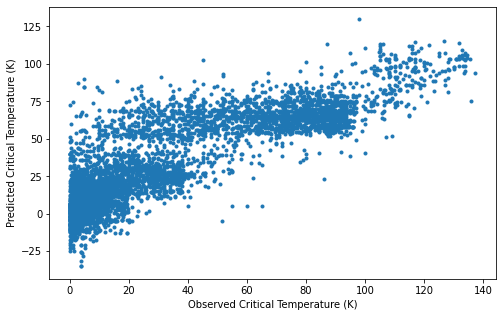

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(y_test_super, y_pred_ridge, '.')
plt.xlabel('Observed Critical Temperature (K)')
plt.ylabel('Predicted Critical Temperature (K)')
plt.show()


A diferencia del artículo "A Data-Driven Statistical Model for Predicting the Critical Temperature of a Superconductor", se encontraron 29 características con alto poder predictivo, basadas en el modelo de `Ridge` y el meta trasformador `SelectFromModel`. Algunas de las econtradas, que también fueron seleccionadas en el artículo son: "weighted mean ThermalConductivity", "weighted  geometric mean ElectronAffinity","weighted standard deviation ElectronAffinity", "weighted  geometric mean Valence", etc.


La figura anterior es comparable con la Figura 8 del artículo (ver abajo), que muestra las temperaturas críticas predichas de superconductores frente a las temperaturas críticas observadas, en este caso, según el modo de Ridge. El valor fuera de muestra ($R^2$) es aproximadamente $0.735$ en contraposición al $R^2 = 0.74$ del artículo.

<img src="figure_8.png">